In [123]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy

from transformers import pipeline
from sklearn.decomposition import PCA

sys.path.append(os.path.abspath(".."))

from data.dataset_factory import get_dataset_generator
from preprocessing.embedding_chunks import get_ready_to_embed_chunks
from preprocessing.mean_pool_chunks import mean_pool_chunks

In [124]:
# Get a random set of functions
gen = get_dataset_generator(
    dataset_name='sourcecodeplag',
    mode='plagiarized',
    **{}
    )
sample = next(gen)
sample = next(gen)
sample = next(gen)
code_a = sample.code_a
code_b = sample.code_b

print(code_a)
print('--'*20)
print(code_b)

import java.util.Scanner;

public class T7 {
	public static void main(String[] args) {
		Scanner input = new Scanner(System.in);

		System.out.print("Enter a 4 by 4 matrix row by row: ");
		double[][] m = new double[4][4];

		for (int i = 0; i < 4; i++)
			for (int j = 0; j < 4; j++)
				m[i][j] = input.nextDouble();

		System.out.print("Sum of the elements in the major diagonal is " + sumMajorDiagonal(m));
	}

	public static double sumMajorDiagonal(double[][] m) {
		double sum = 0;

		for (int i = 0; i < m.length; i++)
			sum += m[i][i];

		return sum;
	}

}

----------------------------------------

import java.util.ArrayList;
import java.util.List;
import java.util.Scanner;

public class arraylebihdarisatu {

    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
        
        
        System.out.print("Enter a 4 by 4 matrix row by row: ");
        double[][] matrix = new double[4][4];//inisialisai array 2 dimensi
                               

In [125]:
model_name = "microsoft/unixcoder-base"
pipe = pipeline("feature-extraction", model=model_name)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2078.07it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: microsoft/unixcoder-base
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


# Split code + AST
Format\
`<s> <encoder-only> Code <AST> AST </AST> </s>`

In [126]:
def embed_sample(sample):
    """
    Embed chunks from a sample
    """
    chunk_a = get_ready_to_embed_chunks(sample.code_a)
    chunk_b = get_ready_to_embed_chunks(sample.code_b)

    embedded_code_a = []
    embedded_code_b = []

    for chunk in chunk_a:
        code = chunk[1]
        emb = pipe(code)
        print("i" + code)
        embedded_code_a.append(emb)


    for chunk in chunk_b:
        code = chunk[1]
        emb = pipe(code)
        embedded_code_b.append(emb)
    
    return embedded_code_a, embedded_code_b

# Visualizing Embedding Spaces for Code A and B Separately

In [127]:
embs = embed_sample(sample)
emb_a = mean_pool_chunks(embs[0])
emb_b = mean_pool_chunks(embs[1])

print("Code A embeddings shape:", emb_a.shape)
print("Code B embeddings shape:", emb_b.shape)

i		Scanner input = new Scanner(System.in);
		System.out.print("Enter a 4 by 4 matrix row by row: ");
		double[][] m = new double[4][4];
i		for (int i = 0; i < 4; i++)
i		System.out.print("Sum of the elements in the major diagonal is " + sumMajorDiagonal(m));
i		double sum = 0;
i		for (int i = 0; i < m.length; i++)
i		return sum;
Code A embeddings shape: (6, 768)
Code B embeddings shape: (6, 768)


# PCA

In [128]:
all_embeddings = np.vstack([emb_a, emb_b])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings)

pca_a = pca_result[:len(emb_a)]
pca_b = pca_result[len(emb_a):]

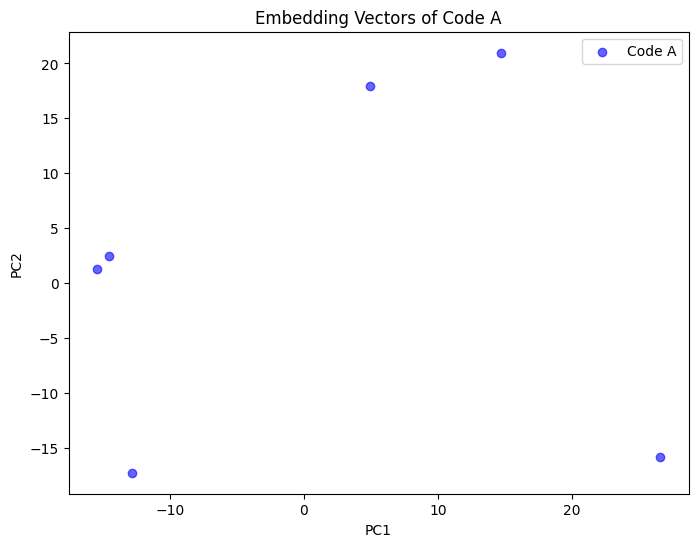

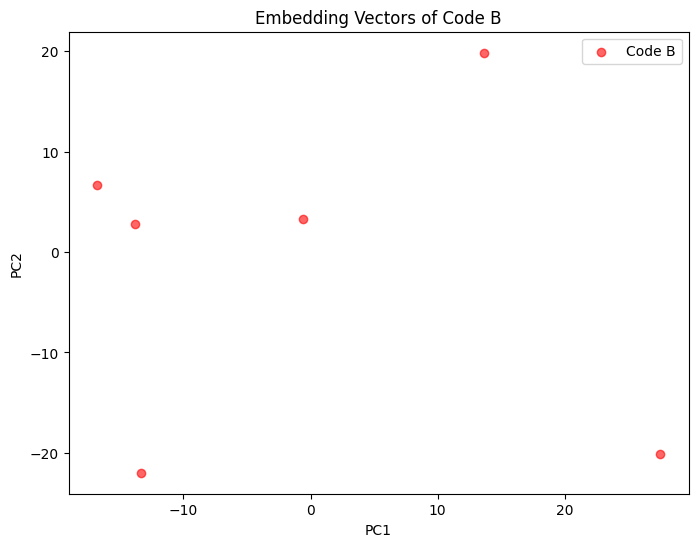

In [129]:
plt.figure(figsize=(8,6))
plt.scatter(pca_a[:,0], pca_a[:,1], color='blue', alpha=0.6, label='Code A')
plt.title("Embedding Vectors of Code A")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(pca_b[:,0], pca_b[:,1], color='red', alpha=0.6, label='Code B')
plt.title("Embedding Vectors of Code B")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

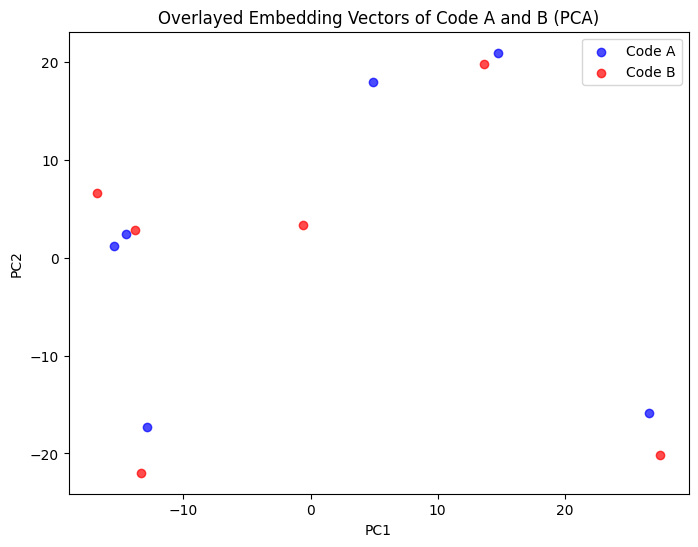

In [130]:
plt.figure(figsize=(8,6))

# Plot Code A
plt.scatter(pca_a[:,0], pca_a[:,1], color='blue', alpha=0.7, label='Code A')

# Plot Code B
plt.scatter(pca_b[:,0], pca_b[:,1], color='red', alpha=0.7, label='Code B')

plt.title("Overlayed Embedding Vectors of Code A and B (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

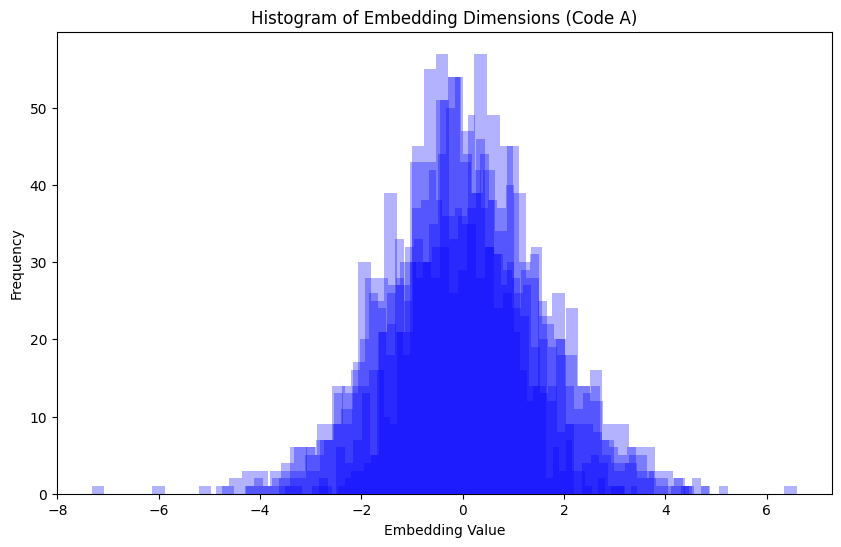

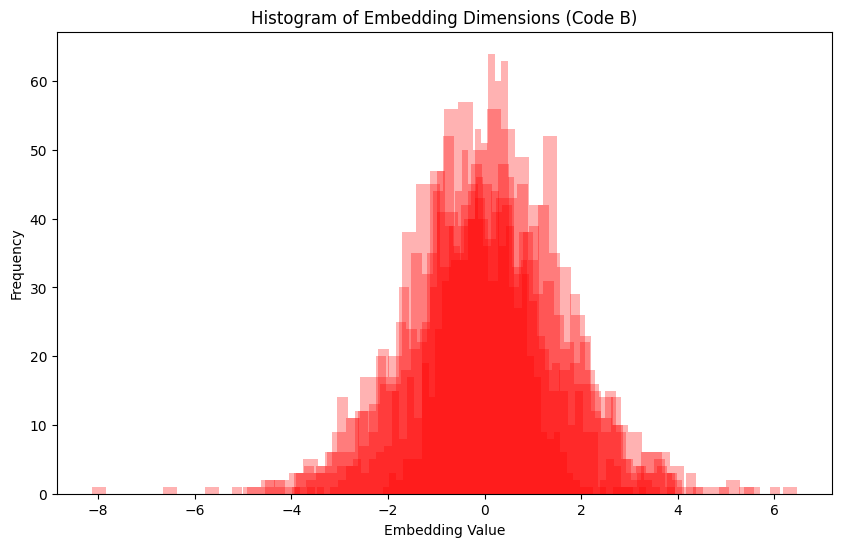

In [131]:
# --- Plot histograms for Code A ---
plt.figure(figsize=(10,6))
for vec in emb_a:  # emb_a: array of shape (num_chunks, embedding_dim)
    plt.hist(vec, bins=50, color='blue', alpha=0.3)  # alpha < 1 for overlap

plt.title("Histogram of Embedding Dimensions (Code A)")
plt.xlabel("Embedding Value")
plt.ylabel("Frequency")
plt.show()

# --- Plot histograms for Code B ---
plt.figure(figsize=(10,6))
for vec in emb_b:
    plt.hist(vec, bins=50, color='red', alpha=0.3)

plt.title("Histogram of Embedding Dimensions (Code B)")
plt.xlabel("Embedding Value")
plt.ylabel("Frequency")
plt.show()

# Cumulative sum

In [172]:
emb_a_ = scipy.signal.savgol_filter(emb_a, 100, 3)
emb_b_ = scipy.signal.savgol_filter(emb_b, 100, 3)


np_a = np.array(emb_a_)
np_b = np.array(emb_b_)

A = np.cumsum(np_a,axis=1)
B = np.cumsum(np_b,axis=1)
p = 1

np.power(np.sum(np.power(np.absolute(A - B), p), axis=1), (1. / p))

array([ 3995.54922616,  4168.7257804 ,  3741.838006  ,  7868.88418033,
       13271.11125075,  5268.76495815])

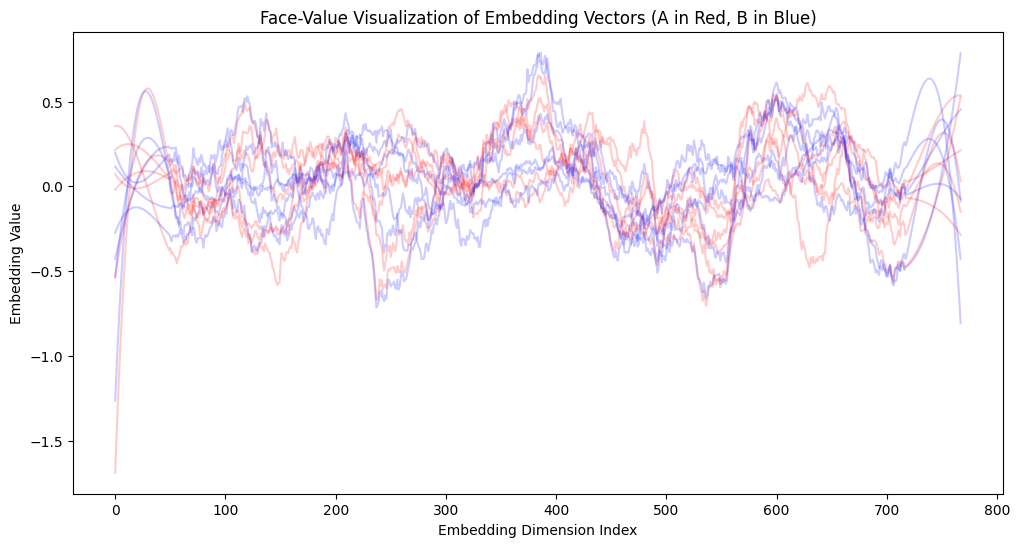

In [173]:
plt.figure(figsize=(12,6))

for vec in emb_a:  # emb_a.shape = (num_chunks, embedding_dim)
    plt.plot(vec, color='red', alpha=0.2)  # red for A, alpha for overlap

for vec in emb_b:
    plt.plot(vec, color='blue', alpha=0.2)  # blue for B

plt.title("Face-Value Visualization of Embedding Vectors (A in Red, B in Blue)")
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Embedding Value")
plt.show()

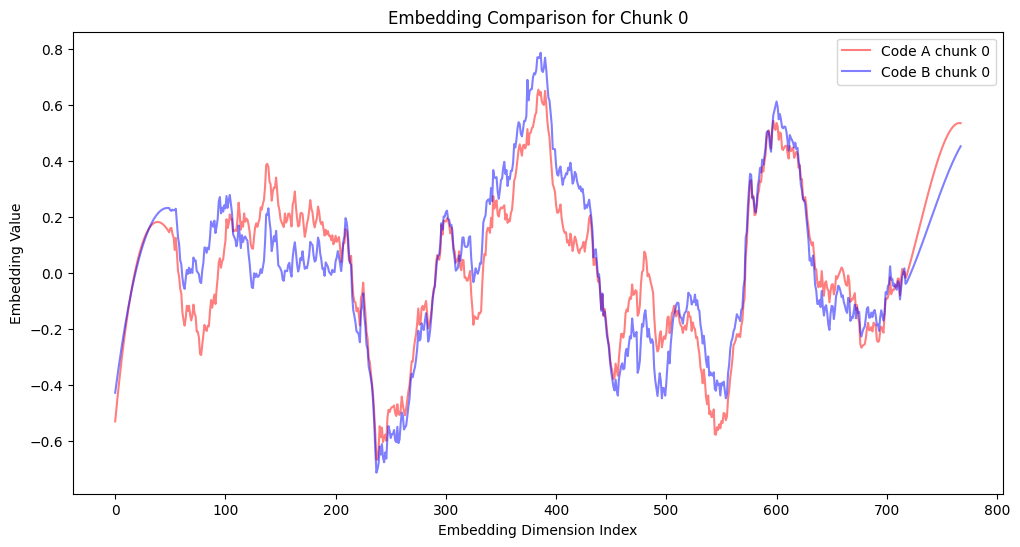

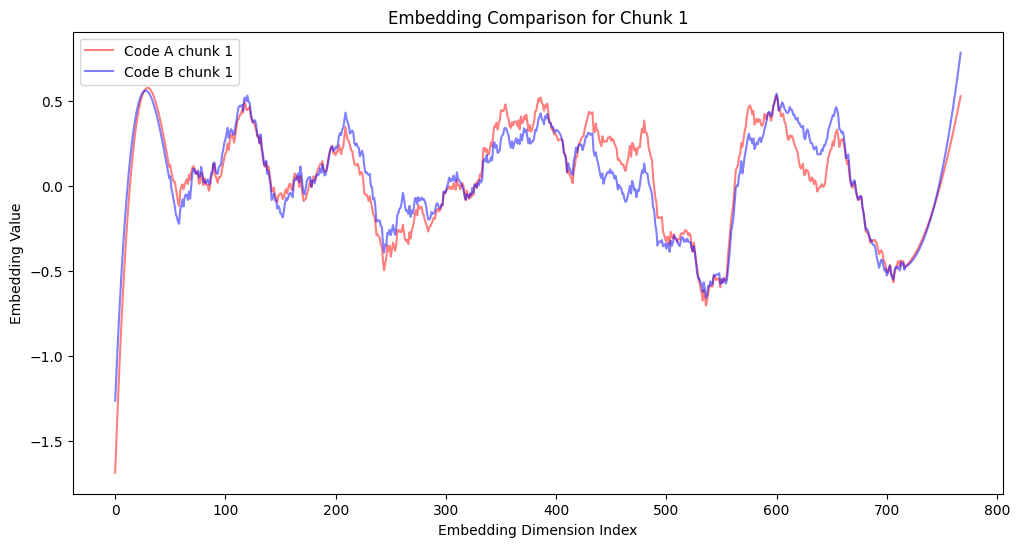

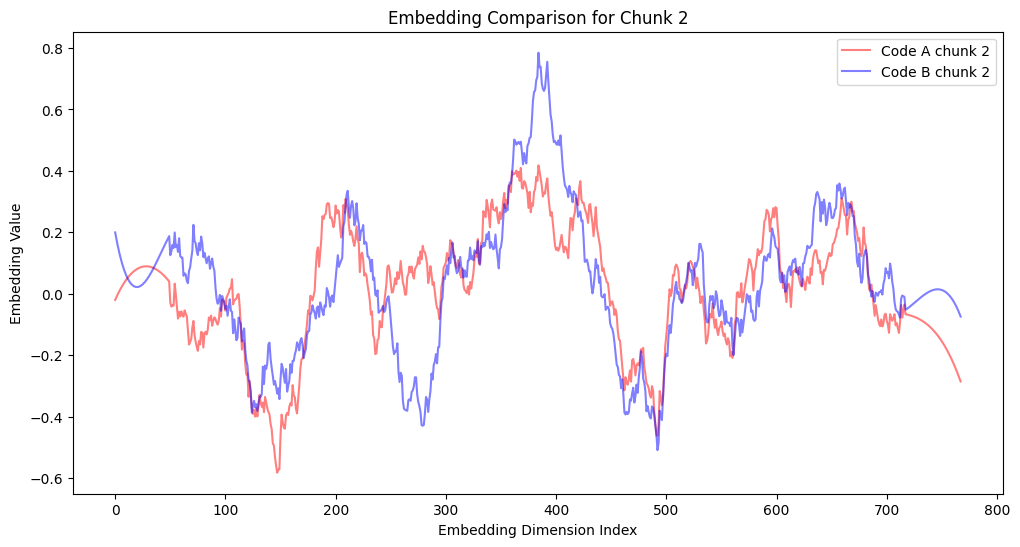

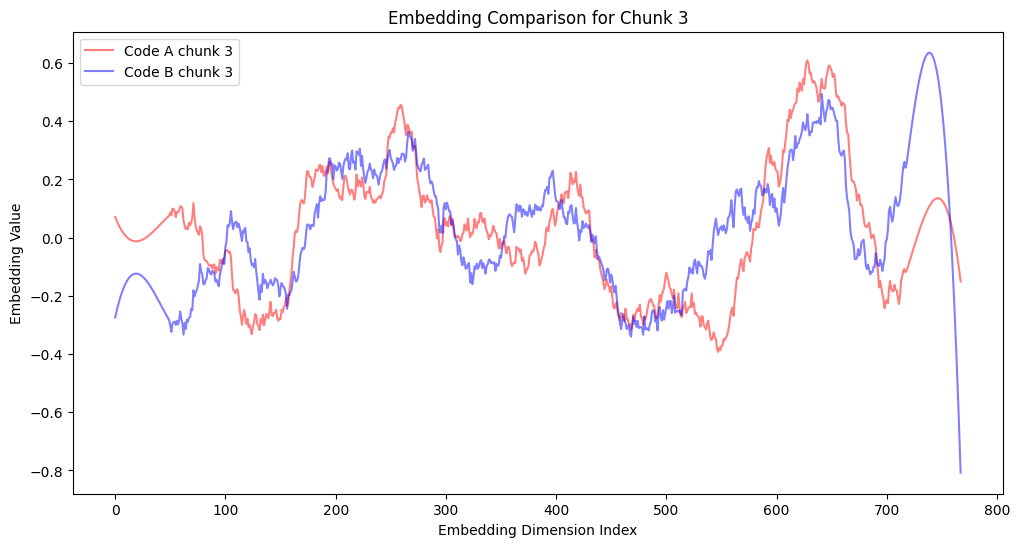

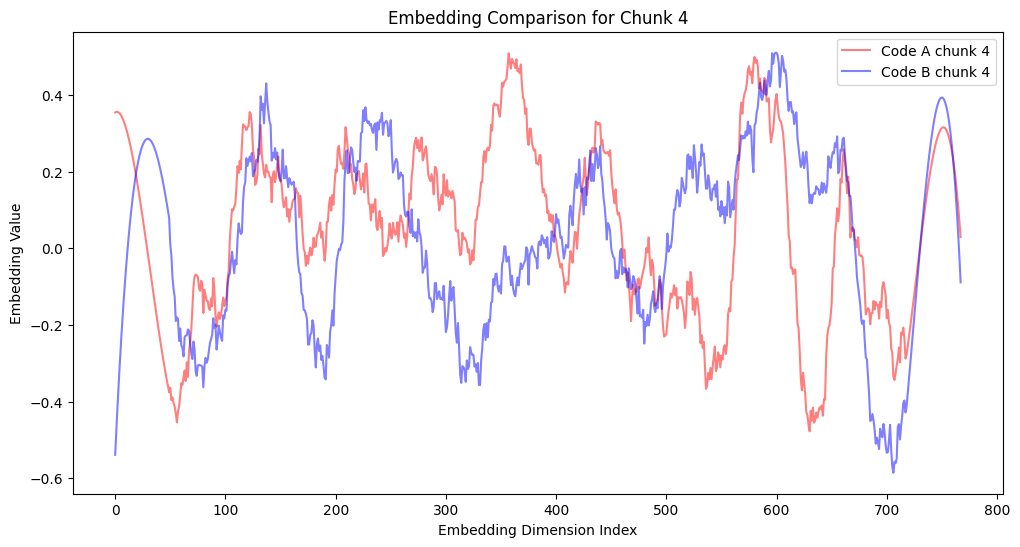

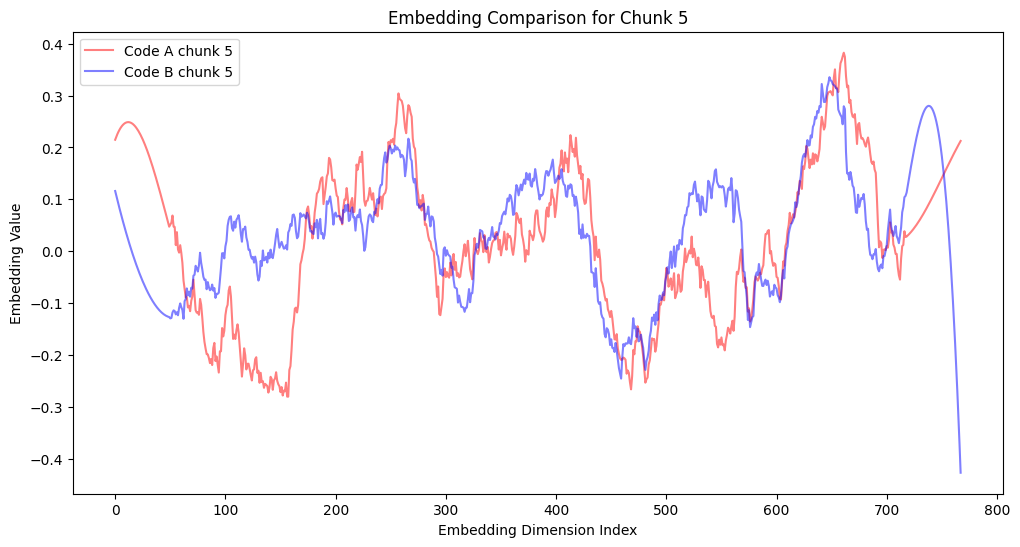

In [174]:
# Determine how many pairs to plot (shortest length of A and B)
num_pairs = min(len(emb_a), len(emb_b))

for i in range(num_pairs):
    plt.figure(figsize=(12,6))
    # Plot A[i] in red
    plt.plot(emb_a[i], color='red', alpha=0.5, label=f'Code A chunk {i}')
    # Plot B[i] in blue
    plt.plot(emb_b[i], color='blue', alpha=0.5, label=f'Code B chunk {i}')
    
    plt.title(f"Embedding Comparison for Chunk {i}")
    plt.xlabel("Embedding Dimension Index")
    plt.ylabel("Embedding Value")
    plt.legend()
    plt.show()